## Q1. Conversion Funnel Deep Dive
​Compute conversion rates across funnel stages ​(Search → Quote → Booking → Completed). Segment by time-of-day Morning (6–10 AM), Day (10 AM–5 PM), Evening (5–9 PM), Night (9 PM–6 AM) and trip length (short <5 km, medium 5–15 km, long >15 km), Identify the maximum drop within each segment.

In [3]:
import os
import pandas as pd
import pytz
folder_path = '/content/drive/My Drive/NY Datathon 2025/NY Datathon 2025'

# Load CSVs
dfs = {}
for file in os.listdir(folder_path):
    if file.endswith('.csv'):
        name = os.path.splitext(file)[0]
        dfs[name] = pd.read_csv(os.path.join(folder_path, file))

# --- Convert UTC to IST  ---
def convert_utc_to_ist(utc_timestamp):
    if pd.isna(utc_timestamp):
        return None
    utc_time = pd.to_datetime(utc_timestamp, utc=True)
    return utc_time.tz_convert('Asia/Kolkata')

# Convert relevant timestamps
time_columns = {
    'search_data': 'search_request_created_at',
    'quote_data': 'quote_created_at',
    'booking_data': 'booking_created_at'
}
for df_name, col in time_columns.items():
    dfs[df_name][col] = pd.to_datetime(dfs[df_name][col], errors='coerce')
    dfs[df_name][f'{col}_ist'] = dfs[df_name][col].apply(convert_utc_to_ist)

# --- Merge all stages ---
merged = (
    dfs['search_data']
    .merge(dfs['quote_data'], on='search_request_id', how='left')
    .merge(dfs['booking_data'], on='quote_id', how='left')
    .merge(dfs['booking_cancellation_data'], on='booking_id', how='left')
)

# --- Segment by time-of-day ---
def time_of_day(hour):
    if 6 <= hour < 10: return 'Morning'
    elif 10 <= hour < 17: return 'Day'
    elif 17 <= hour < 21: return 'Evening'
    else: return 'Night'

merged['hour'] = merged['search_request_created_at'].dt.hour
merged['time_segment'] = merged['hour'].apply(time_of_day)

# --- Segment by trip length ---
def trip_length(dist):
    if pd.isna(dist): return 'Unknown'
    elif dist < 5000: return 'Short'
    elif dist < 15000: return 'Medium'
    else: return 'Long'

merged['trip_segment'] = merged['estimated_distance'].apply(trip_length)

# --- Compute funnel counts ---
stages = ['search_request_id', 'quote_id', 'booking_id', 'status']
funnel = (
    merged.groupby(['time_segment', 'trip_segment'])[stages]
    .count()
    .rename(columns={
        'search_request_id': 'Search',
        'quote_id': 'Quote',
        'booking_id': 'Booking',
        'status': 'Completed'
    })
)

# Completed = only those with status == 'COMPLETED'
completed = (
    merged[merged['status'] == 'COMPLETED']
    .groupby(['time_segment', 'trip_segment'])['booking_id']
    .count()
)
funnel['Completed'] = completed.fillna(0).astype(int)

# --- Conversion rates ---
funnel['Search→Quote%'] = (funnel['Quote'] / funnel['Search']) * 100
funnel['Quote→Booking%'] = (funnel['Booking'] / funnel['Quote']) * 100
funnel['Booking→Completed%'] = (funnel['Completed'] / funnel['Booking']) * 100

# --- Identify maximum drop per segment ---
drop_summary = []
for idx, row in funnel.iterrows():
    rates = {
        'Search→Quote': row['Search→Quote%'],
        'Quote→Booking': row['Quote→Booking%'],
        'Booking→Completed': row['Booking→Completed%']
    }
    lowest_stage = min(rates, key=rates.get)
    drop_summary.append({
        'time_segment': idx[0],
        'trip_segment': idx[1],
        'Max Drop Stage': lowest_stage,
        'Conversion%': rates[lowest_stage]
    })

drop_df = pd.DataFrame(drop_summary)

print("\n--- Funnel Conversion Rates ---")
print(funnel.round(2))

print("\n--- Max Drop per Segment ---")
print(drop_df)



--- Funnel Conversion Rates ---
                           Search   Quote  Booking  Completed  Search→Quote%  \
time_segment trip_segment                                                      
Day          Long          158156   75680    74816      42401          47.85   
             Medium        538123  329720   325772     210282          61.27   
             Short         435111  269454   266239     179730          61.93   
Evening      Long           21342    7607     7517       4256          35.64   
             Medium         37176   20889    20660      13466          56.19   
             Short          26182   16330    16168      10520          62.37   
Morning      Long           76988   32519    32171      21990          42.24   
             Medium        231401  151202   149414     110751          65.34   
             Short         209060  140853   139327      99656          67.37   
Night        Long          130993   63591    62960      39757          48.55   
       

## Q2. Booking Cancellations
Compute the overall cancellation rate. Break down by driver vs rider cancellations, pickup distance buckets and trip distance buckets. Identify the top 3 driver cancellation reasons and analyze their trends over time-of-day and trip length. Analyze the relationship between driver ratings and driver cancellations, and provide key insights​

Overall Cancellation Rate: 32.49%

Cancellation Breakdown by Source:
source
ByDriver         53.77
ByUser           46.08
ByMerchant        0.13
ByApplication     0.02
Name: proportion, dtype: float64

Cancellation Rate by Trip Distance Bucket:
  trip_distance_bucket  total_bookings  cancellations  cancellation_rate_%
0               0–5 km          570274         176512                30.95
1              5–10 km          492720         154496                31.36
2             10–15 km          228418          77246                33.82
3             15–30 km          155924          59310                38.04
4               >30 km           21496           8807                40.97

Top 3 Driver Cancellation Reasons:
reason_code
TRAFFIC_JAM       79430
PICKUP_TOO_FAR    67497
VEHICLE_ISSUE     34857
Name: count, dtype: int64


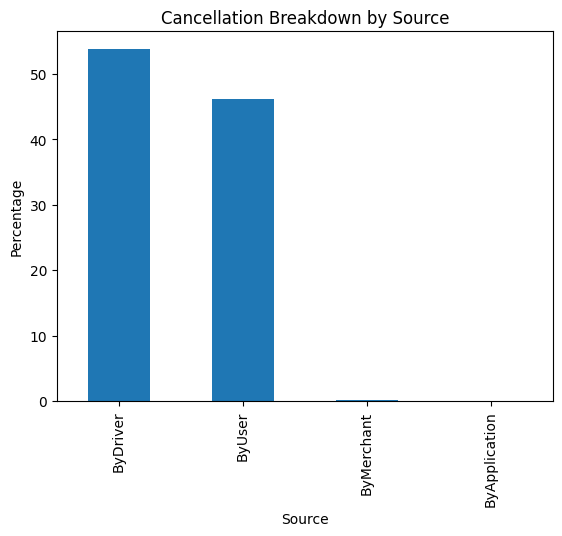

In [9]:
# --- Merge booking data with cancellations ---
merged_cancellations = pd.merge(
    dfs['booking_cancellation_data'],
    dfs['booking_data'][['booking_id', 'quote_id']],
    on='booking_id',
    how='left'
)

# --- Overall cancellation rate ---
total_bookings = dfs['booking_data'].shape[0]
total_cancellations = merged_cancellations.shape[0]
overall_cancellation_rate = (total_cancellations / total_bookings) * 100
print(f"Overall Cancellation Rate: {overall_cancellation_rate:.2f}%")

# --- Driver vs Rider cancellations ---
by_source = merged_cancellations['source'].value_counts(normalize=True) * 100
print("\nCancellation Breakdown by Source:")
print(by_source.round(2))

# Merge cancellations with booking and quote data to get search_request_id
cancelled_with_quote = pd.merge(
    merged_cancellations, dfs['quote_data'], on='quote_id', how='left'
)

# Merge with search data to get estimated_distance
cancelled_with_search = pd.merge(
    cancelled_with_quote, dfs['search_data'], on='search_request_id', how='left'
)

# Define distance bins
bins = [0, 5000, 10000, 15000, 30000, float('inf')]
labels = ['0–5 km', '5–10 km', '10–15 km', '15–30 km', '>30 km']

# Reusing merged_all from the previous cell or creating it if needed
if 'merged_all' not in locals():
    merged_all = pd.merge(
        dfs['booking_data'], dfs['quote_data'], on='quote_id', how='left'
    ).merge(
        dfs['search_data'], on='search_request_id', how='left'
    )

merged_all['trip_distance_bucket'] = pd.cut(
    merged_all['estimated_distance'], bins=bins, labels=labels, right=False
)


# Calculate total bookings per bucket
bookings_by_bucket = (
    merged_all['trip_distance_bucket'].value_counts().rename_axis('trip_distance_bucket')
    .reset_index(name='total_bookings')
)

# Assign distance buckets to the cancelled data
cancelled_with_search['trip_distance_bucket'] = pd.cut(
    cancelled_with_search['estimated_distance'], bins=bins, labels=labels, right=False
)

cancellations_by_bucket = (
    cancelled_with_search['trip_distance_bucket'].value_counts()
    .rename_axis('trip_distance_bucket').reset_index(name='cancellations')
)

# Merge and compute cancellation rates
distance_cxl_rate = pd.merge(bookings_by_bucket, cancellations_by_bucket, on='trip_distance_bucket', how='left')
distance_cxl_rate['cancellation_rate_%'] = (
    distance_cxl_rate['cancellations'] / distance_cxl_rate['total_bookings'] * 100
).round(2)

print("\nCancellation Rate by Trip Distance Bucket:")
print(distance_cxl_rate)

# --- Top 3 Driver Cancellation Reasons ---
driver_cxl = merged_cancellations[merged_cancellations['source'] == 'ByDriver']
top_reasons = driver_cxl['reason_code'].value_counts().head(3)
print("\nTop 3 Driver Cancellation Reasons:")
print(top_reasons)

import matplotlib.pyplot as plt
by_source.plot(kind='bar', title='Cancellation Breakdown by Source')
plt.ylabel('Percentage')
plt.xlabel('Source')
plt.show()

In [6]:
print(dfs['quote_data'].columns)

Index(['quote_id', 'search_request_id', 'driver_id', 'quote_created_at',
       'distance_to_pickup', 'duration_to_pickup', 'driver_rating',
       'estimated_fare', 'quote_created_at_ist'],
      dtype='object')
